### In this part, we would be defining one of the most important metrics, i.e., Customer Lifetime Value (CLTV)

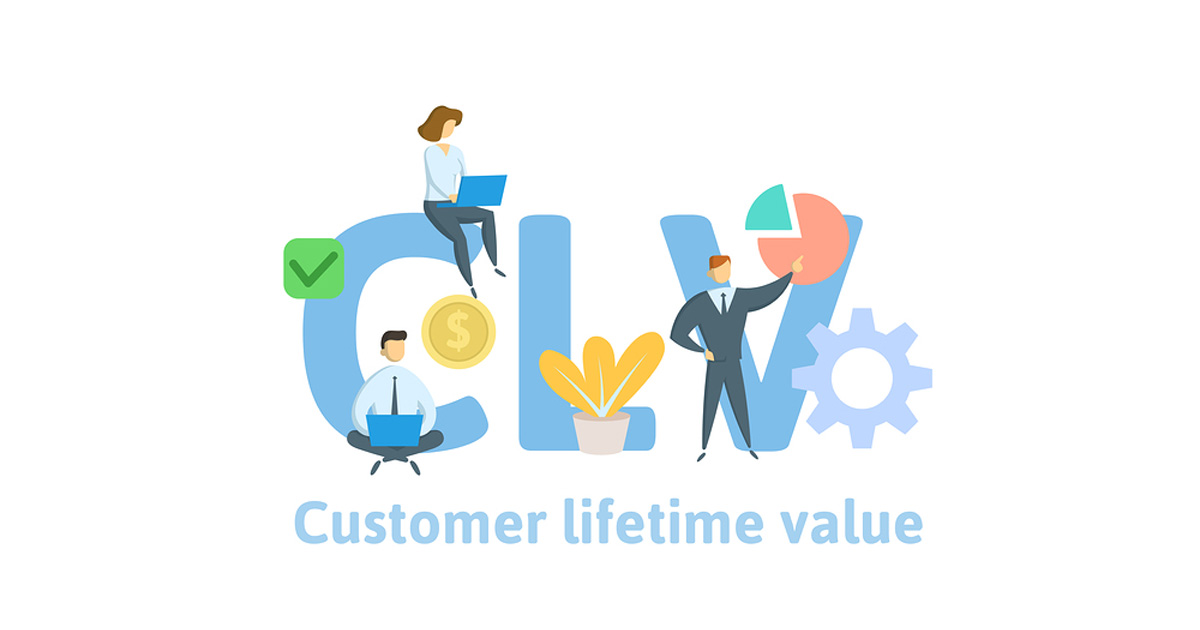
**Companies invest a lot in their customers for acquisition, advertisement, and many other promotional campaigns to generate revenue and be profitable. Implementing these startegies, some customers may turn out to be most valuable, but there are always some customers who can pull down this profitability.**

**CLTV indicates the total revenue from the customer during the entire relationship. CLTV helps companies to focus on those potential customers who can bring in the more revenue in the future.**

**We are going to build a machine learning model that predicts our Customer Lifetime Value.**

**Below are some business problems related to sales that can be solved with the help of Customer Lifetime Value:**  
- **_How can we identify the most profitable customers?_**
- **_How to make most of the money and how to offer the best product?_**
- **_How to segment profitable customers?_**
- **_How much can we spend on budgeting while acquiring new customers?_**

In [77]:
# importing required modules
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import numpy as np

#Modeling
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import xgboost as xgb

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;http://localhost:8888/notebooks/Documents/Pathrise/Project%20Pipeline/e-commerce/Part1%20-%20Analyzing%20Our%20Data%20%26%20Discovering%20the%20Metrics.ipynb#
}
</style>

In [3]:
# Loading Dataset
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Removing Duplicates
df_clean = df[['Country', 'CustomerID']].drop_duplicates()

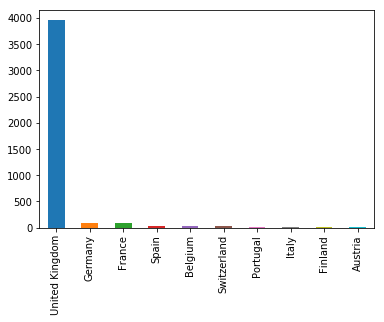

In [6]:
# Top 10 Countries by Customer Base
df_clean.Country.value_counts()[:10].plot(kind='bar');

In [7]:
# Since most of our customers are from United Kingdom, we will use only that part of data

df_uk = df.query("Country == 'United Kingdom'")
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      495478 non-null object
StockCode      495478 non-null object
Description    494024 non-null object
Quantity       495478 non-null int64
InvoiceDate    495478 non-null datetime64[ns]
UnitPrice      495478 non-null float64
CustomerID     361878 non-null float64
Country        495478 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


In [8]:
# Summary Statistics
df_uk.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


_We can see that come of the customers have ordered in negative quantities, which may imply return orders. So, it is good to continue just with positive quantities._

In [32]:
# Filtering for Quantity > 0
df_uk = df_uk.query("Quantity > 0")
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486286 entries, 0 to 541893
Data columns (total 6 columns):
CustomerID     354345 non-null float64
InvoiceDate    486286 non-null datetime64[ns]
InvoiceNo      486286 non-null object
Quantity       486286 non-null int64
UnitPrice      486286 non-null float64
Revenue        486286 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 26.0+ MB


### Data Preparation & Feature Engineering for Calculating CLTV

#### Filtering the required Columns

We will only need five columns, CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice

In [10]:
df_uk = df_uk[['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'UnitPrice']]

In [11]:
# Calculating Revenue as product of Quantity and UnitPrice
df_uk['Revenue'] = df_uk['Quantity'] * df_uk['UnitPrice']

**We have to now engineer some required features based on individual customer level:**
- _Number of Days the customer since customer is with us_  
- _Number of orders_  
- _Sum of Purchase Price_

In [46]:
df_uk_group = df_uk.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                              'InvoiceNo': lambda order: len(order),
                                              'Quantity' : lambda quant: quant.sum(), 
                                              'Revenue': lambda price: price.sum()})

In [47]:
df_uk_group.columns = ['num_days', 'num_orders', 'num_units', 'spent_money']
df_uk_group.head()

,num_days,num_orders,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


### CLTV Formula

_**CLTV = ((Average Order Value x Purcahse Frequency) / Churn Rate) x Profit Margin**_

where,

- Average Order Value: Total Revenue / Total number of Orders  
- Purchase Frequency: Total number of Orders / Total number of Customers  
- Churn Rate: Percentage of customers who do not ordered again  
- Repeat Rate: Number of Customers with more than one Order / Number of Unique Customers

#### Calculating Average Order Value

In [48]:
df_uk_group['avg_order_val'] = df_uk_group['spent_money'] / df_uk_group['num_orders']

#### Calculating Purchase Frequency

In [49]:
purchase_frequency = sum(df_uk_group['num_orders']) / df_uk_group.shape[0]

#### Calculating Repeat & Churn Rate

In [50]:
# Repeat Rate
repeat_rate = df_uk_group.query("num_orders > 1").shape[0] / df_uk_group.shape[0]

# Churn Rate
churn_rate = 1 - repeat_rate

#### Calculating Profit Margin
It represents how much percentage of total sales has earned as gain. We are assuming our business has approx 5% profit on total sale.

In [51]:
df_uk_group['profit_margin'] = df_uk_group['spent_money']*0.05

In [52]:
df_uk_group.head()

,num_days,num_orders,num_units,spent_money,avg_order_val,profit_margin
CustomerID,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800
12747.0,366,103,1275,4196.01,40.737961,209.8005
12748.0,372,4596,25748,33719.73,7.336756,1685.9865
12749.0,209,199,1471,4090.88,20.557186,204.5440
12820.0,323,59,722,942.34,15.971864,47.1170


#### Calculating Customer Lifetime Value

In [53]:
df_uk_group['CLV'] = (df_uk_group['avg_order_val'] * purchase_frequency) / churn_rate
df_uk_group.head()

,num_days,num_orders,num_units,spent_money,avg_order_val,profit_margin,CLV
CustomerID,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,3.852060e+08
12747.0,366,103,1275,4196.01,40.737961,209.8005,2.033140e+05
12748.0,372,4596,25748,33719.73,7.336756,1685.9865,3.661610e+04
12749.0,209,199,1471,4090.88,20.557186,204.5440,1.025963e+05
12820.0,323,59,722,942.34,15.971864,47.1170,7.971198e+04


In [54]:
df_uk_group['CLTV'] = df_uk_group['CLV'] * df_uk_group['profit_margin']
df_uk_group.head()

,num_days,num_orders,num_units,spent_money,avg_order_val,profit_margin,CLV,CLTV
CustomerID,,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,3.852060e+08,1.486579e+12
12747.0,366,103,1275,4196.01,40.737961,209.8005,2.033140e+05,4.265538e+07
12748.0,372,4596,25748,33719.73,7.336756,1685.9865,3.661610e+04,6.173424e+07
12749.0,209,199,1471,4090.88,20.557186,204.5440,1.025963e+05,2.098545e+07
12820.0,323,59,722,942.34,15.971864,47.1170,7.971198e+04,3.755789e+06


### Prediction Model for CLTV
We are going to use Linear Regression to predict CLTV. We are assuming that CLV is total month's sale.


In [56]:
# we will be using the data which was filtered for UK in the start
df_uk.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,Revenue
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [57]:
# Extracting month and year from InvocieDate
df_uk['month_year'] = df_uk['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
df_uk.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,Revenue,month_year
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30,Dec-2010
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00,Dec-2010
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010


In [58]:
# Pivoting our dataframe
sales = df_uk.pivot_table(index=['CustomerID'], 
                          columns=['month_year'], 
                          values='Revenue', 
                          aggfunc='sum', 
                          fill_value=0).reset_index()
sales.head()

month_year,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77


In [60]:
sales['CLV']=sales.iloc[:,2:].sum(axis=1)
sales.head()

month_year,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,77183.60
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00,4196.01
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84,32619.36
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00,4090.88
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77,942.34


#### Selecting Feature
Here, we would be dividing the data into dependent (y - target) and independent (X - input) variables. We will select last 6 months as independent variable. 

In [61]:
X = sales[['Dec-2011', 'Nov-2011', 'Oct-2011', 'Sep-2011', 'Aug-2011', 'Jul-2011']]
y = sales[['CLV']]

#### Splitting Data into Training & Test sets

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # default test_size = 0.25

#### Model Development

In [136]:
# instantiate
linear_model = LinearRegression()

# fitting the model on training set
linear_model.fit(X_train, y_train)

# making predictions on the test sets
y_pred = linear_model.predict(X_test)

In [137]:
# print intercept and coefficients
print(linear_model.intercept_)
print(linear_model.coef_)

[208.50969617]
[[0.99880551 0.80381254 1.60226829 1.67433228 1.52860813 2.87959449]]


#### In order to evaluate the overall fit of the linear model, we use the R-squared value. R-squared is the proportion of variance explained by the model. Value of R-squared lies between 0 and 1. Higher value or R-squared is considered better because it indicates the larger variance explained by the model.

In [138]:
# Compute R squared
print("R-Squared:", metrics.r2_score(y_test, y_pred))

R-Squared: 0.9666074402817513


**_This model has a higher R-squared (0.96). This model provides a better fit to the data._**

### Evaluating the Model Performance

We are using the following evaluation metrics for our Linear Regression Model:  
- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**

In [139]:
# MAE
print("MAE:", metrics.mean_absolute_error(y_test, y_pred))

# MSE
print("MSE:", metrics.mean_squared_error(y_test, y_pred))

# RMSE
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 595.0282284701236
MSE: 2114139.889867891
RMSE: 1454.008215199588


In [164]:
# Splitting with different train and test size 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state=0) # default test_size = 0.25

In [165]:
# instantiate
linear_model = LinearRegression()

# fitting the model on training set
linear_model.fit(X_train, y_train)

# making predictions on the test sets
y_pred = linear_model.predict(X_test)

# print intercept and coefficients
print(linear_model.intercept_)
print(linear_model.coef_)

# Compute R squared
print("R-Squared:", metrics.r2_score(y_test, y_pred))

# MAE
print("MAE:", metrics.mean_absolute_error(y_test, y_pred))

# MSE
print("MSE:", metrics.mean_squared_error(y_test, y_pred))

# RMSE
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[211.03823879]
[[0.99900824 0.76450233 1.62450228 1.6375514  1.52235095 2.92674919]]
R-Squared: 0.9655486752993305
MAE: 590.8993007425962
MSE: 1863005.46246758
RMSE: 1364.9195809525118


In [166]:
RMSE_Reduction = (1454 - 1364)/1454 * 100
RMSE_Reduction

6.189821182943604

**_After changing the size of the training and test sets to 70 and 30 percent respectively, we can seee that there is 6% reduction in RMSE value. RMSE is more popular than MSE and MAE because RMSE is interpretable with y because of the same units._**